In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
statement = "SELECT MAX(date) AS most_recent_date FROM measurement"
result = session.execute(statement)
most_recent_date = None
for row in result:
    most_recent_date = row[0]
most_recent_date

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert most recent date into a date object
date_parts = str(most_recent_date).split("-")
year = int(date_parts[0])
month = int(date_parts[1])
day = int(date_parts[2])

most_recent_date = dt.datetime(year, month, day)

# Calculate the date one year from the last date in data set.
last_12_months = most_recent_date + relativedelta(months=-12)

# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_12_months).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date_list = []
prcp_list = []
for row in result:
    date = row[0]
    prcp = row[1]
    date_list.append(date)
    prcp_list.append(prcp)

data = {
    "Date": date_list,
    "Prcp": prcp_list
}

precipation_pd = pd.DataFrame(data=data)

# Sort the dataframe by date
precipation_pd = precipation_pd.sort_values("Date")
precipation_pd['Prcp'] = precipation_pd["Prcp"].fillna(0)
precipation_pd

# Use Pandas Plotting with Matplotlib to plot the data




,Date,Prcp
0,2016-08-24,0.08
1006,2016-08-24,0.00
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


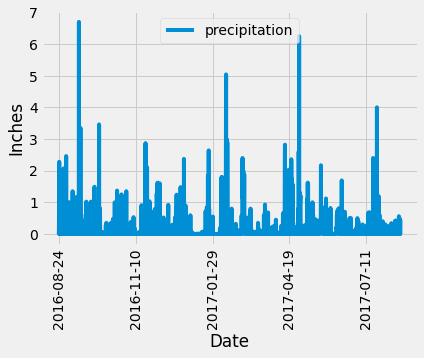

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precipation_pd.set_index("Date", inplace=True)
precipation_pd.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["precipitation"])
plt.show()

# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
statement = "SELECT COUNT(DISTINCT station) AS occurrences FROM measurement"
result = session.execute(statement).first()[0]

result = session.query(func.count(Measurement.station.distinct())).first()
result

(9,)

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
statement = "SELECT station, COUNT(*) AS occurrences FROM measurement GROUP BY station ORDER BY occurrences DESC"
result = session.execute(statement).all()
for row in result:
    print(row)

# List station id with the highest number of observations
highest_occurrences = max([i[1] for i in result])
highest_station_id = [i[0] for i in result if i[1] == highest_occurrences][0]
highest_station_id

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


'USC00519281'

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)).filter_by(station=highest_station_id).all()[0]
print(f"Min_temp = {result[0]}, Max_temp = {result[1]}, Avg_temp = {result[2]}")


Min_temp = 54.0, Max_temp = 85.0, Avg_temp = 71.66378066378067


In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the most recent date and convert it tinto a datetime object
statement = f"SELECT MAX(date) FROM measurement"
latest_date = session.execute(statement).all()[0][0]
latest_date_parts = str(latest_date).split("-")
year = int(latest_date_parts[0])
month = int(latest_date_parts[1])
day = int(latest_date_parts[2])
latest_date = dt.datetime(year, month, day)
print(f"The latest date is {latest_date}")

# Calculate the time delta of the last 12 months from the latest date
twelve_months_ago = latest_date + relativedelta(months=-12)
print(f"Time delta is {twelve_months_ago}")


The latest date is 2017-08-23 00:00:00
Time delta is 2016-08-23 00:00:00


In [17]:
# Filter by the station with the highest number of observations
# [0] index, [1] station id, [2] date, [3] prcp, [4] tobs
statement = f"""SELECT tobs
            FROM measurement
            WHERE date > '{twelve_months_ago}'
            AND station = '{highest_station_id}'"""
result = session.execute(statement).all()

# Convert into a DataFrame
tobs_list = [i[0] for i in result]
data = {
    "Temperature": tobs_list
}
tobs_pd = pd.DataFrame(data=data)
tobs_pd
# tobs_pd.hist(bins=12)
# plt.title("")
# plt.xlabel("Temperature")
# plt.ylabel("Frequency")
# plt.legend(["tobs"])
# plt.show()

,Temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


# Close session

In [51]:
# Close Session
session.close()